# Jigsaw Unintended Bias in Toxicity Classification

#### Since the data we have contains sequence pattren, Here in this file I am trying the same problem with using bidirectional LSTM and GRU, which typically perfroms great on sequential data.

##### Reference  :https://www.theseus.fi/bitstream/handle/10024/226938/Quan_Do.pdf?sequence=2&isAllowed=y

In [ ]:
#For Data loading and preprocessing
import pandas as pd

#For matrix operations
import numpy as np

#For Ploting
import matplotlib.pyplot as plt
%matplotlib inline

#Useful in text-preprocessing
import re
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer

#Importing all keras necessary modules
import keras
from keras.models import Sequential,Model,load_model
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional,add,GRU,Input,concatenate,GlobalMaxPooling1D,GlobalAveragePooling1D,SpatialDropout1D,CuDNNLSTM,CuDNNGRU
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.optimizers import *

##To see the progress of the iterations
from tqdm import tqdm

#For splitting the data
from sklearn.model_selection import train_test_split

#Performance metrices
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,auc,log_loss,confusion_matrix,make_scorer

#For ignoring deprication warnings
import warnings
warnings.filterwarnings("ignore")
import keras.backend as K
from keras.models import load_model

In [0]:
#To read the file form google-drive
#Ref: https://www.youtube.com/watch?v=oqMImCeXi6o
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
#Getting authorization from drive to read the file
#Ref: https://www.youtube.com/watch?v=oqMImCeXi6o
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1bVz4c1W16bTmEWThVuVQ9haktmlCXn4i'})
downloaded.GetContentFile('data_processed.csv')

In [6]:
#Getting all preprocessed data
data = pd.read_csv("data_processed.csv")
data.head()

,target,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness,preprocessed_reviews,word_count,comment_length,num_bad_words,len_bad_words,profinity_frequency,profinity_len_frequency,profinity_mul,profinity_sum,profinity_HM
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,cool like would want mother read really great ...,11,60,0,0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,thank would make life lot less anxiety inducin...,14,75,0,0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,urgent design problem kudos taking impressive,6,45,0,0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,something able install site releasing,5,37,0,0,0.0,0.0,0.0,0.0,0.0
4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,haha guys bunch losers,4,22,0,0,0.0,0.0,0.0,0.0,0.0


In [0]:
#For appling DL algorithms we do not require hand crafted features (of course that's the beauty of DL)
X = data['preprocessed_reviews'] #Hence taking only preprocessed text as input


#Taking all output labels  
Y = data[['target',
 'severe_toxicity',
 'obscene',
 'threat',
 'insult',
 'identity_attack',
 'sexual_explicit',
 'male',
 'female',
 'homosexual_gay_or_lesbian',
 'christian',
 'jewish',
 'muslim',
 'black',
 'white',
 'psychiatric_or_mental_illness']]

#Spliting the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42,shuffle=False)

In [8]:
ALL_labels= Y.columns.to_list() # list of all output label names  
ALL_labels

['target',
 'severe_toxicity',
 'obscene',
 'threat',
 'insult',
 'identity_attack',
 'sexual_explicit',
 'male',
 'female',
 'homosexual_gay_or_lesbian',
 'christian',
 'jewish',
 'muslim',
 'black',
 'white',
 'psychiatric_or_mental_illness']

In [0]:
def get_aux_labels(df):
    return df[['target']],df[['severe_toxicity','obscene','threat','insult','identity_attack',
 'sexual_explicit']],df[['male','female','homosexual_gay_or_lesbian','christian','jewish','muslim','black','white','psychiatric_or_mental_illness']]

In [0]:
y_train_target,y_train_aux_target,y_train_identity = get_aux_labels(y_train)

y_test_target,y_test_aux_target,y_test_identity = get_aux_labels(y_test)

In [0]:
# Defing own AUC based metric,specially mentioned for this competition
# This code was inspired from :https://www.kaggle.com/kenkrige/subgroup-analysis

def AUC(df_y):

    fpr, tpr, thresholds = roc_curve(df_y["actual"],df_y["predict"],pos_label=1)
    return auc(fpr, tpr)

def Mp(data, p=-5.0):
    return np.average(data.astype(float) ** p) ** (1/p)


def final_AUC_metric(y_true, y_predicted,final_AUC_metric_alone=True):
        
    IDENTITY_labels = ["male",
                       "female",
                       "homosexual_gay_or_lesbian",
                       "christian",
                       "jewish",
                       "muslim",
                       "black",
                       "white",
                       "psychiatric_or_mental_illness"]
    y_true= pd.DataFrame(y_true, columns=ALL_labels).reset_index(drop=True)  #Converting Actual output arrays to dataframes with same labels  
    y_predicted= pd.DataFrame(y_predicted, columns=ALL_labels).reset_index(drop=True) #Converting Predicted output arrays to dataframes with same labels  
    
    y_df = pd.DataFrame(y_true['target'].to_list(), columns=["actual"]) #putting only ['target'] values of both "y_true" and "y_predicted" into single DF
    y_df["predict"]=y_predicted['target'].to_list()
    

    
    results = pd.DataFrame(columns = ['SUB', 'BPSN', 'BNSP'], index = IDENTITY_labels) # Created to collect all AUCs
    
    overall = AUC(df_y=y_df)  #This overall AUC (diretly between (y_true['target'],y_predicted['target']  )
    
    for label in IDENTITY_labels: # Calculating BPSN and BNSP for each identity label 
        y_true[label] = y_true[label] == 1
        y_true['target'] = y_true['target']==1
        
        bpsn = y_true[label]^y_true['target']    
        bnsp = ~(y_true[label]^y_true['target'])
        
        results.loc[label,'BPSN']= AUC(df_y = y_df[bpsn]) 
        results.loc[label,'BNSP']= AUC(df_y = y_df[bnsp])
        results.loc[label,'SUB']=  AUC(df_y = y_df[y_true[label]])

    results.loc['Mp',:] = results.apply(Mp, axis= 0)

    

    final_auc = ((results.loc['Mp',:].sum()) + overall) / 4

    if final_AUC_metric_alone:
        return final_auc
    else:
        return final_auc, results
#final_AUC = make_scorer(final_AUC_metric, greater_is_better=True,final_AUC_metric_alone=True)

In [0]:
#Ref: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
tokens = Tokenizer()
tokens.fit_on_texts(X_train)
vocab_size = len(tokens.word_index) + 1
# integer encode the documents
X_train_ints = tokens.texts_to_sequences(X_train)

X_test_ints = tokens.texts_to_sequences(X_test)

max_length = 500 #Setting equal length of 500 for every comment_text
X_train_ints = pad_sequences(X_train_ints, maxlen=max_length, padding='post')

X_test_ints = pad_sequences(X_test_ints, maxlen=max_length, padding='post')

In [0]:
#Getting 'glove.6B.100d.txt' file 
downloaded = drive.CreateFile({'id':'11hKZPIxqRbmisbmfUW36VM8RNzfkYkYF'}) # replace the id with id of file you want to access
downloaded.GetContentFile('glove.6B.100d.txt') 

In [14]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [15]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tqdm(tokens.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 217265/217265 [00:00<00:00, 524255.73it/s]


### 1. Bi-directional GRU (Two 128-units) 

In [0]:

input_s = Input(shape=(max_length,), dtype='int32', name='input_s')

GRUs = Embedding(input_dim=vocab_size,input_length=max_length,weights=[embedding_matrix],trainable=False,output_dim=embedding_matrix.shape[1])(input_s)

GRUs = SpatialDropout1D(0.3)(GRUs)

GRUs = Bidirectional(GRU(128, return_sequences=True))(GRUs)
GRUs = Bidirectional(GRU(128, return_sequences=True))(GRUs)
hidden1 = concatenate([GlobalMaxPooling1D()(GRUs),GlobalAveragePooling1D()(GRUs) ])

hidden2 = add([hidden1, Dense(512, activation='relu')(hidden1)])
hidden3 = add([hidden2, Dense(512, activation='relu')(hidden2)])

#Multi_Outputs
result = Dense(1, activation='sigmoid',name='result')(hidden3) #target
aux_result = Dense(y_train_aux_target.shape[1], activation='sigmoid',name='aux_result')(hidden3) #
identity_result = Dense(y_train_identity.shape[1], activation='sigmoid',name='identity_result')(hidden3)

model = Model(inputs=input_s, outputs=[result, aux_result,identity_result])
adam = Adam(lr= 0.0006)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_s (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 500, 100)     21726600    input_s[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_12 (SpatialDr (None, 500, 100)     0           embedding_12[0][0]               
__________________________________________________________________________________________________
bidirectional_21 (Bidirectional (None, 500, 256)     175872      spatial_dropout1d_12[0][0]       
__________________________________________________________________________________________________
bidirectio

In [0]:
history = model.fit(
{'input_s': X_train_ints},
{'result': y_train_target,
    'aux_result':y_train_aux_target,
    'identity_result':y_train_identity},
batch_size=512,
epochs=4,
validation_data=[{'input_s': X_test_ints},
                  {'result': y_test_target,
          'aux_result':y_test_aux_target,
          'identity_result':y_test_identity}])

Train on 1249618 samples, validate on 535551 samples
Epoch 1/4
 298496/1249618 [======>.......................] - ETA: 6:51:40 - loss: 0.2906 - result_loss: 0.1944 - aux_result_loss: 0.0451 - identity_result_loss: 0.0511 - result_acc: 0.9322 - aux_result_acc: 0.9876 - identity_result_acc: 0.9861

In [0]:
#History of fitting
pd.DataFrame(history.history)

,aux_result_acc,aux_result_loss,identity_result_acc,identity_result_loss,loss,result_acc,result_loss,val_aux_result_acc,val_aux_result_loss,val_identity_result_acc,val_identity_result_loss,val_loss,val_result_acc,val_result_loss
0,0.989538,0.034499,0.992251,0.024733,0.225061,0.939478,0.165829,0.989867,0.030094,0.996385,0.010376,0.193054,0.941003,0.152584
1,0.990756,0.027901,0.996242,0.010442,0.181899,0.945788,0.143556,0.990254,0.028192,0.996741,0.009067,0.182248,0.943636,0.144990
2,0.991033,0.026496,0.996598,0.009376,0.173214,0.947805,0.137342,0.989904,0.028607,0.996760,0.008939,0.185810,0.941750,0.148265
3,0.991199,0.025709,0.996747,0.008941,0.168440,0.948536,0.133790,0.990508,0.027050,0.996938,0.008527,0.177589,0.944000,0.142012


In [0]:
downloaded = drive.CreateFile({'id':'1OYzd8cAlefRcDPM3TGc9zosvGDwYbYei'})
downloaded.GetContentFile('GRU_128_model.h5')

In [17]:
#model.save('GRU_128_model.h5')
model_1 = load_model('GRU_128_model.h5')





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
prediction_train_GRU = model_1.predict(X_train_ints,batch_size=1024)


results_train_GRU   = final_AUC_metric(y_true=y_train, y_predicted=np.hstack((prediction_train_GRU[0],prediction_train_GRU[1],prediction_train_GRU[2]))
                          ,final_AUC_metric_alone=False)

In [19]:
print("Individual AUCs for all identity lables in train data.")
print("-----------------------------------------------------------")
results_train_GRU[1]

Individual AUCs for all identity lables in train data.
-----------------------------------------------------------


,SUB,BPSN,BNSP
male,0.919915,0.899428,0.970506
female,0.920779,0.903863,0.969247
homosexual_gay_or_lesbian,0.839443,0.803015,0.974197
christian,0.928425,0.940823,0.951624
jewish,0.891134,0.870905,0.969504
muslim,0.858035,0.822108,0.97438
black,0.837163,0.787605,0.976653
white,0.851046,0.79152,0.978752
psychiatric_or_mental_illness,0.924017,0.893697,0.972906
Mp,0.880937,0.847051,0.970687


In [20]:
print("Final AUC value for Train data:")
results_train_GRU[0]

Final AUC value for Train data:


0.9143455841898749

In [0]:
prediction_test_GRU = model_1.predict(X_test_ints,batch_size=1024)


results_test_GRU   = final_AUC_metric(y_true=y_test, y_predicted=np.hstack((prediction_test_GRU[0],prediction_test_GRU[1],prediction_test_GRU[2]))
                          ,final_AUC_metric_alone=False)

In [22]:
print("Individual AUCs for all identity lables in Test data.")
print("-----------------------------------------------------------")
results_test_GRU[1]

Individual AUCs for all identity lables in Test data.
-----------------------------------------------------------


,SUB,BPSN,BNSP
male,0.90492,0.883349,0.964173
female,0.904801,0.893481,0.959032
homosexual_gay_or_lesbian,0.824629,0.792441,0.968468
christian,0.921393,0.931261,0.944542
jewish,0.872002,0.844679,0.964684
muslim,0.855626,0.8085,0.97034
black,0.822899,0.755966,0.975351
white,0.833,0.759401,0.976705
psychiatric_or_mental_illness,0.882848,0.858177,0.962593
Mp,0.864885,0.824491,0.964836


In [23]:
print("Final AUC value for Test data:")
results_test_GRU[0]

Final AUC value for Test data:


0.9011745407645806

### 2. Bidirectional-LSTM  (Two 128-units)

In [0]:
input_s = Input(shape=(max_length,), dtype='int32', name='input_s')

LSTMs = Embedding(input_dim=vocab_size,input_length=max_length,weights=[embedding_matrix],trainable=False,output_dim=embedding_matrix.shape[1])(input_s)

LSTMs = SpatialDropout1D(0.3)(LSTMs)

LSTMs = Bidirectional(CuDNNLSTM(128, return_sequences=True))(LSTMs)
LSTMs = Bidirectional(CuDNNLSTM(128, return_sequences=True))(LSTMs)
hidden1 = concatenate([GlobalMaxPooling1D()(LSTMs),GlobalAveragePooling1D()(LSTMs)])

hidden2 = add([hidden1, Dense(512, activation='relu')(hidden1)])
hidden3 = add([hidden2, Dense(512, activation='relu')(hidden2)])

#Multi_Outputs
result = Dense(1, activation='sigmoid',name='result')(hidden3) #target
aux_result = Dense(y_train_aux_target.shape[1], activation='sigmoid',name='aux_result')(hidden3) #
identity_result = Dense(y_train_identity.shape[1], activation='sigmoid',name='identity_result')(hidden3)

model = Model(inputs=input_s, outputs=[result, aux_result,identity_result])
adam = Adam(lr= 0.0006)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_s (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 500, 100)     21726600    input_s[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 500, 100)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 500, 256)     235520      spatial_dropout1d_2[0][0]        
____________________________________________________________________________________________

In [0]:
history2 = model.fit(
{'input_s': X_train_ints},
{'result': y_train_target,
    'aux_result':y_train_aux_target,
    'identity_result':y_train_identity},
batch_size=512,
epochs=4,
validation_data=[{'input_s': X_test_ints},
                  {'result': y_test_target,
          'aux_result':y_test_aux_target,
          'identity_result':y_test_identity}])

Train on 1249618 samples, validate on 535551 samples
Epoch 1/4
1249618/1249618 [==============================] - 3047s 2ms/step - loss: 0.1813 - result_loss: 0.1426 - aux_result_loss: 0.0279 - identity_result_loss: 0.0107 - result_acc: 0.9460 - aux_result_acc: 0.9907 - identity_result_acc: 0.9961 - val_loss: 0.1811 - val_result_loss: 0.1443 - val_aux_result_loss: 0.0279 - val_identity_result_loss: 0.0088 - val_result_acc: 0.9434 - val_aux_result_acc: 0.9903 - val_identity_result_acc: 0.9968
Epoch 2/4
1249618/1249618 [==============================] - 3050s 2ms/step - loss: 0.1724 - result_loss: 0.1368 - aux_result_loss: 0.0264 - identity_result_loss: 0.0092 - result_acc: 0.9477 - aux_result_acc: 0.9910 - identity_result_acc: 0.9966 - val_loss: 0.1801 - val_result_loss: 0.1439 - val_aux_result_loss: 0.0277 - val_identity_result_loss: 0.0085 - val_result_acc: 0.9432 - val_aux_result_acc: 0.9902 - val_identity_result_acc: 0.9969
Epoch 3/4
1249618/1249618 [==============================] 

In [0]:
pd.DataFrame(history2.history)

,val_loss,val_result_loss,val_aux_result_loss,val_identity_result_loss,val_result_acc,val_aux_result_acc,val_identity_result_acc,loss,result_loss,aux_result_loss,identity_result_loss,result_acc,aux_result_acc,identity_result_acc
0,0.181065,0.144323,0.027929,0.008814,0.943376,0.990332,0.996846,0.181293,0.142645,0.027932,0.010716,0.946046,0.990726,0.996118
1,0.180093,0.143864,0.027730,0.008500,0.943221,0.990188,0.996912,0.172393,0.136766,0.026383,0.009244,0.947725,0.991018,0.996632
2,0.173211,0.138562,0.026483,0.008166,0.945553,0.990601,0.997029,0.166786,0.132715,0.025423,0.008649,0.948801,0.991216,0.996832
3,0.175894,0.140708,0.026990,0.008196,0.944368,0.990302,0.996942,0.163348,0.130132,0.024850,0.008366,0.949770,0.991329,0.996926


In [0]:
downloaded = drive.CreateFile({'id':'1CH5hrfHfMXkmZykXTy1CCmuk23mTRGzE'})
downloaded.GetContentFile('LSTM_128_model.h5')

In [0]:
#model.save('LSTM_128_model.h5')
model_LSTM = load_model('LSTM_128_model.h5')

In [0]:
prediction_test_LSTM = model_LSTM.predict(X_test_ints,batch_size=1024)

results_test_LSTM = final_AUC_metric(y_true=y_test, y_predicted=np.hstack((prediction_test_LSTM[0],prediction_test_LSTM[1],prediction_test_LSTM[2]))
                          ,final_AUC_metric_alone=False)

In [0]:
prediction_train_LSTM = model_LSTM.predict(X_test_ints,batch_size=1024)

results_train_LSTM = final_AUC_metric(y_true=y_test, y_predicted=np.hstack((prediction_train_LSTM[0],prediction_train_LSTM[1],prediction_train_LSTM[2]))
                          ,final_AUC_metric_alone=False)

In [28]:
print("Individual AUCs for all identity lables in train data")
print("-----------------------------------------------------------")
results_train_LSTM[1]

Individual AUCs for all identity lables in train data
-----------------------------------------------------------


,SUB,BPSN,BNSP
male,0.909608,0.913021,0.953612
female,0.909311,0.929136,0.941677
homosexual_gay_or_lesbian,0.833091,0.815263,0.96553
christian,0.925166,0.944067,0.937236
jewish,0.871444,0.906045,0.936999
muslim,0.857696,0.866571,0.954591
black,0.835007,0.80147,0.969378
white,0.837532,0.813361,0.967609
psychiatric_or_mental_illness,0.890834,0.893438,0.953436
Mp,0.870565,0.866693,0.952895


In [29]:
print("Final AUC value on train data:")
results_train_LSTM[0]

Final AUC value on train data:


0.9106687666503256

In [30]:
print("Individual AUCs for all identity lables in test data.")
print("-----------------------------------------------------------")
results_test_LSTM[1]

Individual AUCs for all identity lables in test data.
-----------------------------------------------------------


,SUB,BPSN,BNSP
male,0.909608,0.913021,0.953612
female,0.909311,0.929136,0.941677
homosexual_gay_or_lesbian,0.833091,0.815263,0.96553
christian,0.925166,0.944067,0.937236
jewish,0.871444,0.906045,0.936999
muslim,0.857696,0.866571,0.954591
black,0.835007,0.80147,0.969378
white,0.837532,0.813361,0.967609
psychiatric_or_mental_illness,0.890834,0.893438,0.953436
Mp,0.870565,0.866693,0.952895


In [31]:
print("Final AUC value on Test data:")
results_test_LSTM[0]

Final AUC value on Test data:


0.9106687666503256

### 3.  LSTM  (One - 256 hidden states) 


In [0]:
input_s = Input(shape=(max_length,), dtype='int32', name='input_s')

LSTMs = Embedding(input_dim=vocab_size,input_length=max_length,weights=[embedding_matrix],trainable=False,output_dim=embedding_matrix.shape[1])(input_s)

LSTMs = SpatialDropout1D(0.3)(LSTMs)

LSTMs = Bidirectional(CuDNNLSTM(256, return_sequences=True))(LSTMs)
hidden1 = concatenate([GlobalMaxPooling1D()(LSTMs),GlobalAveragePooling1D()(LSTMs)])
hidden2 = add([hidden1, Dense(1024, activation='relu')(hidden1)])

#Multi_Outputs
result = Dense(1, activation='sigmoid',name='result')(hidden2) #target
aux_result = Dense(y_train_aux_target.shape[1], activation='sigmoid',name='aux_result')(hidden2) #
identity_result = Dense(y_train_identity.shape[1], activation='sigmoid',name='identity_result')(hidden2)

model = Model(inputs=input_s, outputs=[result, aux_result,identity_result])
adam = Adam(lr= 0.0007)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_s (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 100)     21726600    input_s[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 500, 100)     0           embedding_1[0][0]                
_____________________________________________________________________

In [0]:
history3 = model.fit(
{'input_s': X_train_ints},
{'result': y_train_target,
    'aux_result':y_train_aux_target,
    'identity_result':y_train_identity},
batch_size=512,
epochs=4,
validation_data=[{'input_s': X_test_ints},
                  {'result': y_test_target,
          'aux_result':y_test_aux_target,
          'identity_result':y_test_identity}])



Train on 1249618 samples, validate on 535551 samples
Epoch 1/4
1249618/1249618 [==============================] - 2866s 2ms/step - loss: 0.2279 - result_loss: 0.1677 - aux_result_loss: 0.0349 - identity_result_loss: 0.0253 - result_acc: 0.9390 - aux_result_acc: 0.9896 - identity_result_acc: 0.9922 - val_loss: 0.1946 - val_result_loss: 0.1534 - val_aux_result_loss: 0.0306 - val_identity_result_loss: 0.0106 - val_result_acc: 0.9414 - val_aux_result_acc: 0.9898 - val_identity_result_acc: 0.9963
Epoch 2/4
1249618/1249618 [==============================] - 2863s 2ms/step - loss: 0.1848 - result_loss: 0.1457 - aux_result_loss: 0.0284 - identity_result_loss: 0.0106 - result_acc: 0.9449 - aux_result_acc: 0.9906 - identity_result_acc: 0.9961 - val_loss: 0.1892 - val_result_loss: 0.1499 - val_aux_result_loss: 0.0297 - val_identity_result_loss: 0.0095 - val_result_acc: 0.9411 - val_aux_result_acc: 0.9897 - val_identity_result_acc: 0.9966
Epoch 3/4
1249618/1249618 [==============================

In [0]:
pd.DataFrame(history3.history)

,val_loss,val_result_loss,val_aux_result_loss,val_identity_result_loss,val_result_acc,val_aux_result_acc,val_identity_result_acc,loss,result_loss,aux_result_loss,identity_result_loss,result_acc,aux_result_acc,identity_result_acc
0,0.194591,0.153394,0.030552,0.010645,0.941367,0.989836,0.996310,0.227909,0.167698,0.034901,0.025310,0.939030,0.989604,0.992207
1,0.189182,0.149889,0.029750,0.009543,0.941076,0.989679,0.996605,0.184755,0.145734,0.028380,0.010641,0.944915,0.990562,0.996145
2,0.186362,0.148611,0.028573,0.009178,0.942063,0.990146,0.996684,0.176091,0.139645,0.027030,0.009416,0.946781,0.990858,0.996583
3,0.177034,0.141100,0.027267,0.008667,0.944523,0.990323,0.996806,0.171139,0.136010,0.026207,0.008922,0.948019,0.991028,0.996736


In [0]:
downloaded = drive.CreateFile({'id':'1z05A9DKdh-lL2B3Q6sbQZPOthr8Rjix2'})
downloaded.GetContentFile('LSTM_1_256_model.h5')

In [0]:
#model.save('LSTM_1_256_model.h5')
model_3 = load_model('LSTM_1_256_model.h5')


In [0]:
prediction_train_1_LSTM = model_3.predict(X_test_ints,batch_size=1024)

results_train_1_LSTM = final_AUC_metric(y_true=y_test, y_predicted=np.hstack((prediction_train_1_LSTM[0],prediction_train_1_LSTM[1],prediction_train_1_LSTM[2]))
                          ,final_AUC_metric_alone=False)


In [0]:
prediction_test_1_LSTM = model_3.predict(X_test_ints,batch_size=1024)

results_test_1_LSTM = final_AUC_metric(y_true=y_test, y_predicted=np.hstack((prediction_test_1_LSTM[0],prediction_test_1_LSTM[1],prediction_test_1_LSTM[2]))
                          ,final_AUC_metric_alone=False)

In [36]:
print("Individual AUCs for all identity lables in train data")
print("-----------------------------------------------------------")
results_train_1_LSTM[1]

Individual AUCs for all identity lables in train data
-----------------------------------------------------------


,SUB,BPSN,BNSP
male,0.904342,0.901972,0.954225
female,0.904459,0.909357,0.94949
homosexual_gay_or_lesbian,0.83211,0.794553,0.968925
christian,0.920784,0.932199,0.942574
jewish,0.878474,0.862827,0.959182
muslim,0.859851,0.822205,0.967435
black,0.829509,0.760894,0.974761
white,0.835397,0.781142,0.972463
psychiatric_or_mental_illness,0.881831,0.841916,0.966623
Mp,0.868237,0.833763,0.9614


In [37]:
print("Final AUC value on train data:")
results_train_1_LSTM[0]

Final AUC value on train data:


0.9032849964785521

In [38]:
print("Individual AUCs for all identity lables in test data.")
print("-----------------------------------------------------------")
results_test_1_LSTM[1]

Individual AUCs for all identity lables in test data.
-----------------------------------------------------------


,SUB,BPSN,BNSP
male,0.904342,0.901972,0.954225
female,0.904459,0.909357,0.94949
homosexual_gay_or_lesbian,0.83211,0.794553,0.968925
christian,0.920784,0.932199,0.942574
jewish,0.878474,0.862827,0.959182
muslim,0.859851,0.822205,0.967435
black,0.829509,0.760894,0.974761
white,0.835397,0.781142,0.972463
psychiatric_or_mental_illness,0.881831,0.841916,0.966623
Mp,0.868237,0.833763,0.9614


In [39]:
print("Final AUC value on Test data:")
results_test_1_LSTM[0]

Final AUC value on Test data:


0.9032849964785521

### 4. GRU  (One 256 hidden states)

In [0]:
input_s = Input(shape=(max_length,), dtype='int32', name='input_s')

GRUs = Embedding(input_dim=vocab_size,input_length=max_length,weights=[embedding_matrix],trainable=False,output_dim=embedding_matrix.shape[1])(input_s)

GRUs = SpatialDropout1D(0.3)(GRUs)

GRUs = Bidirectional(CuDNNGRU(256, return_sequences=True))(GRUs)

hidden1 = concatenate([GlobalMaxPooling1D()(GRUs),GlobalAveragePooling1D()(GRUs)])
hidden2 = add([hidden1, Dense(1024, activation='relu')(hidden1)])

#Multi_Outputs
result = Dense(1, activation='sigmoid',name='result')(hidden2) #target
aux_result = Dense(y_train_aux_target.shape[1], activation='sigmoid',name='aux_result')(hidden2) #
identity_result = Dense(y_train_identity.shape[1], activation='sigmoid',name='identity_result')(hidden2)

model = Model(inputs=input_s, outputs=[result, aux_result,identity_result])
adam = Adam(lr= 0.0005)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_s (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 500, 100)     21726600    input_s[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 500, 100)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 500, 512)     549888      spatial_dropout1d_2[0][0]        
____________________________________________________________________________________________

In [0]:
history4 = model.fit(
{'input_s': X_train_ints},
{'result': y_train_target,
    'aux_result':y_train_aux_target,
    'identity_result':y_train_identity},
batch_size=512,
epochs=4,
validation_data=[{'input_s': X_test_ints},
                  {'result': y_test_target,
          'aux_result':y_test_aux_target,
          'identity_result':y_test_identity}])

Train on 1249618 samples, validate on 535551 samples
Epoch 1/4
1249618/1249618 [==============================] - 2487s 2ms/step - loss: 0.2312 - result_loss: 0.1691 - aux_result_loss: 0.0355 - identity_result_loss: 0.0266 - result_acc: 0.9385 - aux_result_acc: 0.9894 - identity_result_acc: 0.9920 - val_loss: 0.1953 - val_result_loss: 0.1532 - val_aux_result_loss: 0.0307 - val_identity_result_loss: 0.0114 - val_result_acc: 0.9409 - val_aux_result_acc: 0.9897 - val_identity_result_acc: 0.9960
Epoch 2/4
1249618/1249618 [==============================] - 2491s 2ms/step - loss: 0.1889 - result_loss: 0.1487 - aux_result_loss: 0.0290 - identity_result_loss: 0.0112 - result_acc: 0.9441 - aux_result_acc: 0.9905 - identity_result_acc: 0.9960 - val_loss: 0.1963 - val_result_loss: 0.1560 - val_aux_result_loss: 0.0298 - val_identity_result_loss: 0.0105 - val_result_acc: 0.9389 - val_aux_result_acc: 0.9897 - val_identity_result_acc: 0.9962
Epoch 3/4
1249618/1249618 [==============================] 

In [0]:
model.save('GRU_1_256_model.h5')
pd.DataFrame(history4.history)

,val_loss,val_result_loss,val_aux_result_loss,val_identity_result_loss,val_result_acc,val_aux_result_acc,val_identity_result_acc,loss,result_loss,aux_result_loss,identity_result_loss,result_acc,aux_result_acc,identity_result_acc
0,0.195335,0.153217,0.030708,0.011410,0.940906,0.989720,0.996038,0.231219,0.169134,0.035499,0.026586,0.938533,0.989436,0.991955
1,0.196322,0.156028,0.029822,0.010472,0.938940,0.989660,0.996193,0.188907,0.148745,0.028961,0.011201,0.944113,0.990497,0.995955
2,0.196817,0.156024,0.030717,0.010076,0.937978,0.989213,0.996365,0.180836,0.143124,0.027687,0.010026,0.945809,0.990725,0.996386
3,0.189954,0.150645,0.029276,0.010034,0.940054,0.989694,0.996335,0.175893,0.139526,0.026882,0.009486,0.947126,0.990891,0.996569


In [0]:
downloaded = drive.CreateFile({'id':'1VYdyO56a_1S5K_doQ6JbgImlkKqv8K-D'})
downloaded.GetContentFile('GRU_1_256_model.h5')

In [0]:
model_4 = load_model("GRU_1_256_model.h5")

In [0]:
prediction_test_1_GRU = model_4.predict(X_test_ints,batch_size=1024)

results_test_1_GRU = final_AUC_metric(y_true=y_test, y_predicted=np.hstack((prediction_test_1_GRU[0],prediction_test_1_GRU[1],prediction_test_1_GRU[2]))
                          ,final_AUC_metric_alone=False)

In [0]:
prediction_train_1_GRU = model_4.predict(X_test_ints,batch_size=1024)

results_train_1_GRU = final_AUC_metric(y_true=y_test, y_predicted=np.hstack((prediction_train_1_GRU[0],prediction_train_1_GRU[1],prediction_train_1_GRU[2]))
                          ,final_AUC_metric_alone=False)

In [48]:
print("Individual AUCs for all identity lables in train data")
print("-----------------------------------------------------------")
results_train_1_GRU[1]

Individual AUCs for all identity lables in train data
-----------------------------------------------------------


,SUB,BPSN,BNSP
male,0.902507,0.901582,0.951306
female,0.902052,0.907382,0.947442
homosexual_gay_or_lesbian,0.82361,0.818157,0.958555
christian,0.917903,0.935986,0.933674
jewish,0.878121,0.882712,0.948481
muslim,0.856564,0.841832,0.958798
black,0.8258,0.785789,0.967613
white,0.835534,0.791343,0.968554
psychiatric_or_mental_illness,0.876612,0.869772,0.953081
Mp,0.864923,0.850496,0.953837


In [49]:
print("Final AUC value on train data:")
results_train_1_GRU[0]

Final AUC value on train data:


0.9041943263064994

In [50]:
print("Individual AUCs for all identity lables in test data.")
print("-----------------------------------------------------------")
results_test_1_GRU[1]

Individual AUCs for all identity lables in test data.
-----------------------------------------------------------


,SUB,BPSN,BNSP
male,0.902507,0.901582,0.951306
female,0.902052,0.907382,0.947442
homosexual_gay_or_lesbian,0.82361,0.818157,0.958555
christian,0.917903,0.935986,0.933674
jewish,0.878121,0.882712,0.948481
muslim,0.856564,0.841832,0.958798
black,0.8258,0.785789,0.967613
white,0.835534,0.791343,0.968554
psychiatric_or_mental_illness,0.876612,0.869772,0.953081
Mp,0.864923,0.850496,0.953837


In [51]:
print("Final AUC value on Test data:")
print("-----------------------------------------------------------")
results_test_1_GRU[0]

Final AUC value on Test data:
-----------------------------------------------------------


0.9041943263064994

### Final Results

In [15]:
pd.DataFrame(
             ([results_test_LSTM[0],results_train_LSTM[0]],[results_test_GRU[0],results_train_GRU[0]],
                [results_test_1_LSTM[0],results_train_1_LSTM[0]],[results_test_1_GRU[0],results_train_1_GRU[0]]),
                 columns=['Test_Toxic_AUC','Train_Toxic_AUC'],index=['2-LSTM','2-GRU','1-LSTM','1-GRU'])

,Test_Toxic_AUC,Train_Toxic_AUC
2-LSTM,0.910669,0.910669
2-GRU,0.901175,0.914346
1-LSTM,0.903285,0.903285
1-GRU,0.904194,0.904194


### Evaluating with Kaggle Test Data using 2-LSTM

In [0]:
downloaded = drive.CreateFile({'id':'1QShQ1iPAWA4IZ_CVbZblxyIWr6SPpCnu'})
downloaded.GetContentFile('test.csv')

In [0]:
test_data = pd.read_csv("test.csv")
test_data.head()

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...
3,7097323,"Paul: Thank you for your kind words. I do, in..."
4,7097324,Sorry you missed high school. Eisenhower sent ...


In [0]:
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# we are including them into stop words list


stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

def preprocess_text(data):
    """References : 1. remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
                 2. remove spacial character: https://stackoverflow.com/a/5843547/4084039
                 3. https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
    """

    preprocessed_reviews = []

    for sentance in tqdm(data['comment_text'].values):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        preprocessed_reviews.append(sentance.strip())
    sequence=tokens.texts_to_sequences(preprocessed_reviews)
    return pad_sequences(sequence, maxlen=max_length, padding='post')
     

In [0]:
test_text_data =  preprocess_text(data=test_data)
test_text_data.shape

100%|██████████| 97320/97320 [00:34<00:00, 2820.69it/s]


(97320, 500)

In [0]:
prediction_test_LSTM = model_LSTM.predict(test_text_data,batch_size=1024)

In [0]:
save_submission = pd.DataFrame(zip(test_data['id'].values,np.squeeze(prediction_test_LSTM[0])),columns=['id','prediction'])
save_submission.to_csv('submit',index=False)

#### On submitting the above file on Kaggle, achieved 91.456% Toxic AUC on test data  

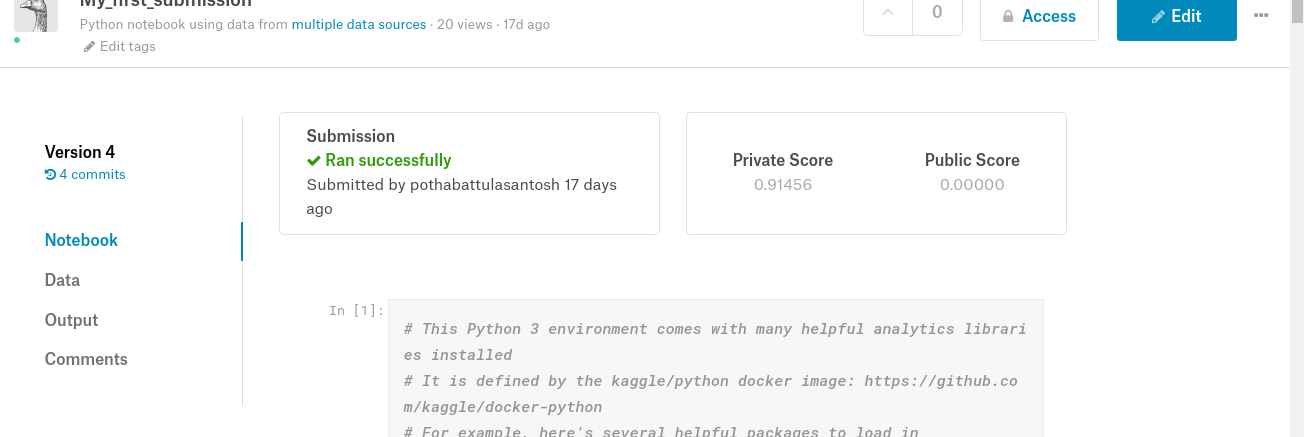